In [1]:
import numpy as np
from neuralStellar2_1 import NNmodel,Teff2colour
import pymc3 as pm
import theano.tensor as T
import pandas as pd
import matplotlib.pyplot as plt
from astropy import constants
import corner

### Loading in data, NNs, setting Av, dist_mod, Mbol and Teff_sun

In [39]:
m1=NNmodel('evo',['mass','age','feh','MLT'],['radius','Teff','delnu','star_feh'],Teff_scaling=5000)
m1.loadModel('Ran_files/b7/b7_best_model.h5', summary=False)
m1.getWeights()

t1=Teff2colour(['log_Teff','logg','[Fe/H]','Av'],['Bessell_U','Bessell_B','Bessell_V','Bessell_R','Bessell_I','Gaia_G_MAW','Gaia_BP_MAWb','Gaia_BP_MAWf','Gaia_RP_MAW'])
t1.loadModel('Post-handin/test6.h5', summary=False)
t1.getWeights()

M67 = pd.read_csv('data_collection/NGC_2682/NGC_2682_post_dwarfs_binaries.csv')
#M67 = M67.sample(n=100)
N = len(M67.index)

[Av, dist_mod] = [0.160758, 9.660732908839677]
Mbol = 4.75
Teff_sun = 5776.02970722

M67[['ID','g_mag','Bp_Rp','distance','gaia_lum']]

,ID,g_mag,Bp_Rp,distance,gaia_lum
0,598678141384872704,14.216938,0.816884,895.432688,1.291100
1,598687865190906496,14.027311,0.791509,861.349992,1.410116
2,598689926775182208,15.439061,1.085226,856.055255,0.420243
3,598691885280238464,15.112228,0.990932,864.238230,0.551021
4,598692675554477056,14.430771,0.861522,853.822720,0.965335
...,...,...,...,...,...
349,608002408009810176,14.124716,0.817037,889.533594,1.384906
350,608021516319899648,14.939761,0.936432,876.861341,0.656688
351,608024333818424448,14.062884,0.819704,869.420401,1.397698
352,608027151316994048,14.457603,0.859469,873.912494,0.990203


### A mock up cluster generation check overlaied on the data

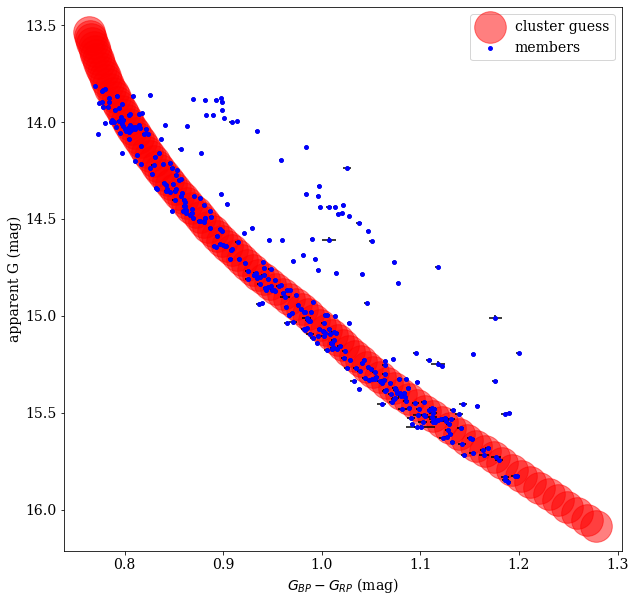

In [47]:
TN = 100
Tmass = np.linspace(0.8,1.20,TN)
Tage = np.ones(TN)*3.5
Tfeh = np.ones(TN)*0.1
TY = np.ones(TN)*0.255
TMLT = np.ones(TN)*2.1

Tobs = m1.predict([Tmass,Tage,Tfeh,TY,TMLT])

TTeff = 10**Tobs[1]
TL = 10**Tobs[0]
Tradius_sq = TL/((TTeff/Teff_sun)**4)
Tlogg = np.log10(100*constants.G.value*(Tmass/Tradius_sq)*(constants.M_sun.value/constants.R_sun.value**2))
TAv = np.ones(TN)*Av

TBCs = t1.model.predict(np.array([np.log10(TTeff),Tlogg,Tfeh,TAv]).T).T

TBCg = TBCs[5]
TBCbp = TBCs[7]
TBCrp = TBCs[8]

TmG = -2.5*np.log10(TL)+Mbol-TBCg+dist_mod
TBp_Rp = TBCrp - TBCbp

fig, ax=plt.subplots(1,1, figsize=(10,10))
#ax.plot(TBp_Rp,TmG,'k.',zorder=1,label='cluster guess')
ax.scatter(TBp_Rp, TmG, s=1000, zorder=1, c='red', label='cluster guess', alpha=0.5)
ax.errorbar(M67['Bp_Rp'], M67['g_mag'], xerr=M67['Bp_Rp_err'], yerr=M67['g_mag_err']*10, fmt='.', zorder=2, c='black')
ax.scatter(M67['Bp_Rp'], M67['g_mag'], s=15, zorder=3, c='blue', label='members')
ax.set_xlabel(r'$G_{BP}-G_{RP}$ (mag)')
ax.set_ylabel('apparent G (mag)')
ax.set_ylim(ax.get_ylim()[::-1])
ax.legend()
plt.show()

### The HBM model

In [31]:
model = pm.Model()
with model:
    #cluster-wide fundamentals
    Age_mu = pm.Deterministic('mean_age',pm.Beta('a',10,10)*2+2.5)
    feh_mu = pm.Deterministic('mean_feh',pm.Beta('e',10,10)*0.4-0.2)
    Y_mu = pm.Deterministic('mean_Y',pm.Beta('f',10,10)*0.04+0.24)
    MLT_mu = pm.Deterministic('mean_MLT',pm.Beta('g',10,10)*0.6+1.7)
    
    #per star fundamentals
    M = pm.Deterministic('mass', pm.Beta('d',10,10,shape=N)*(1.33-0.8)+0.8)
    Age = pm.Deterministic('age',T.ones(N)*Age_mu)
    feh = pm.Deterministic('feh',T.ones(N)*feh_mu)
    Y = pm.Deterministic('Y',T.ones(N)*Y_mu)
    MLT = pm.Deterministic('MLT',T.ones(N)*MLT_mu)
    
    #NN calculation
    obs = pm.Deterministic('obs',m1.manualPredict(T.log10([M, Age, 10**feh, Y, MLT])))
    
    #intermediate observables
    radius = pm.Deterministic('radius', 10**obs[0])
    Teff = pm.Deterministic('Teff', (10**obs[1])*5000)
    L = pm.Deterministic('L', (radius**2)*((Teff/Teff_sun)**4))
    logg = pm.Deterministic('logg', T.log10(100*constants.G.value*(M/radius**2)*(constants.M_sun.value/constants.R_sun.value**2)))
    Av_list = pm.Deterministic('Av', T.ones(N)*Av)
    
    #second NN calculation
    BCs = pm.Deterministic('BCs', t1.manualPredict(T.as_tensor_variable([T.log10(Teff), logg, feh, Av_list])))
    
    #BCs
    BCg = pm.Deterministic('BCg', BCs[5,:])
    BCbp = pm.Deterministic('BCbp', BCs[7,:])
    BCrp = pm.Deterministic('BCrp', BCs[8,:])
    
    #true observables
    true_mG = pm.Deterministic('true_mG', -2.5*T.log10(L)+Mbol-BCg+dist_mod)
    true_Bp_Rp = pm.Deterministic('true_Bp_Rp', BCrp-BCbp)
    
    #dealing with multiples
    #q = pm.Beta('q', 7, 2, testval=0.7)
    q = pm.Dirichlet('q', a=np.ones(3))
    #delta_mG = pm.Normal('delta_mG', 0.75, 0.2, testval=0.75)
    dist_singular = pm.Normal.dist(0, M67['g_mag_err']*100)
    dist_multiple = pm.Normal.dist(-0.75, 0.2)
    dist_C = pm.Normal.dist(-0.2, 0.1)
    
    #obs observables
    obs_mG = pm.Mixture('obs_mG', w=q, comp_dists = [dist_singular, dist_multiple, dist_C], \
                        observed=M67['g_mag'].values-true_mG)
    obs_Bp_Rp = pm.Normal('obs_Bp_Rp', true_Bp_Rp, M67['Bp_Rp_err'], observed=M67['Bp_Rp'])

In [32]:
trace= pm.load_trace(directory='pymc3_traces/M67_post33', model=model)

In [25]:
start = {'mean_age':3.5, 'mean_feh':0.1, 'mean_Y':0.26, 'mean_MLT':2.0}
with model:
    trace = pm.sample(50,tune=50, init='adapt_diag', start=start, target_accept=0.999, cores=1, chains=2)

#pm.save_trace(trace, directory='M67_trace1', overwrite=True)

Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [q, d, g, f, e, a]
Sampling chain 1, 0 divergences: 100%|███████████████████████████████████████████████| 100/100 [07:47<00:00,  4.67s/it]
C:\Users\User\anaconda3\lib\site-packages\pymc3\sampling.py:496: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


In [33]:
summary = pm.summary(trace, var_names=['mean_age','mean_feh','mean_Y','mean_MLT','q'])
summary

C:\Users\User\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_age,2.611,0.033,2.551,2.672,0.002,0.002,234.0,234.0,211.0,908.0,1.02
mean_feh,0.125,0.003,0.119,0.131,0.000,0.000,99.0,99.0,98.0,377.0,1.04
mean_Y,0.242,0.001,0.241,0.243,0.000,0.000,123.0,123.0,126.0,955.0,1.03
mean_MLT,2.272,0.008,2.257,2.286,0.000,0.000,395.0,395.0,405.0,1069.0,1.01
q[0],0.648,0.028,0.591,0.695,0.001,0.000,2448.0,2448.0,2553.0,1316.0,1.00
q[1],0.104,0.017,0.071,0.134,0.000,0.000,3000.0,2881.0,3007.0,1219.0,1.00
q[2],0.248,0.026,0.199,0.295,0.001,0.000,2293.0,2102.0,2434.0,1576.0,1.00


C:\Users\User\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


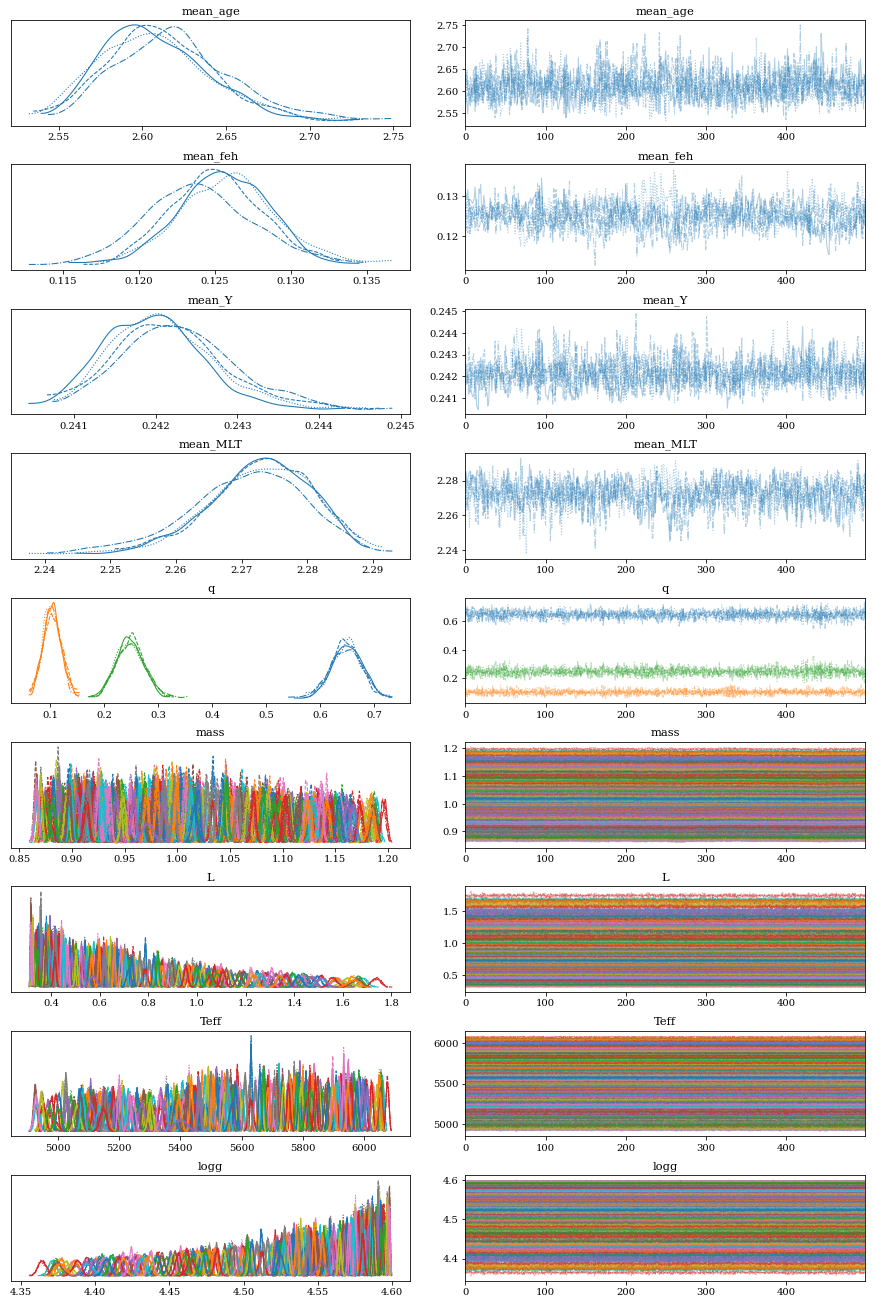

In [34]:
pm.plots.traceplot(trace,var_names=['mean_age','mean_feh','mean_Y','mean_MLT','q',
                                    'mass',
                                    'L','Teff','logg'],compact=True)
#pm.plots.traceplot(trace,var_names=['mean_Y','spread_Y'])
plt.show()

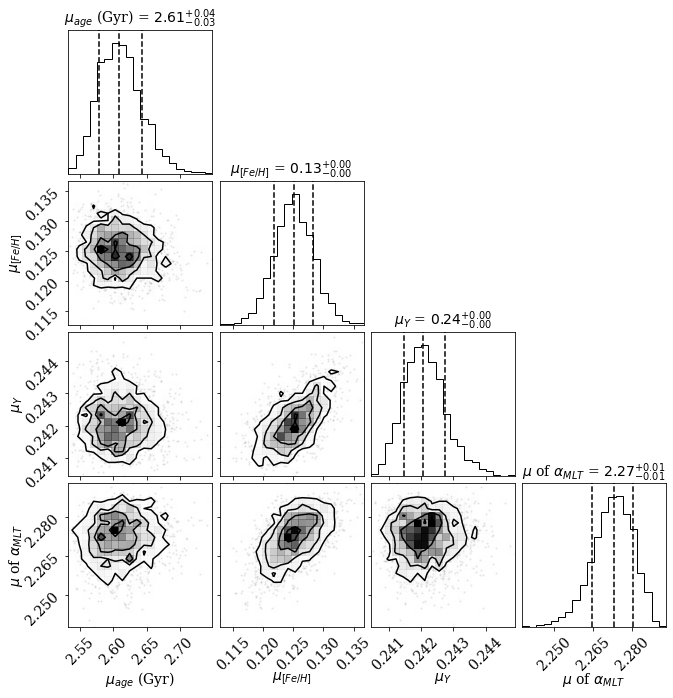

In [36]:
#corner plots
corner.corner(np.array([trace['mean_age'],trace['mean_feh'],trace['mean_Y'],trace['mean_MLT']]).T,
#corner.corner(np.array([trace['mean_age'],trace['spread_age'],trace['mean_feh'],trace['spread_feh'],trace['mean_Y'],trace['spread_Y'],trace['mean_MLT'],trace['q'],trace['delta_mG']]).T,
              labels=[r'$\mu_{age}$ (Gyr)',r'$\mu_{[Fe/H]}$',
                      r'$\mu_{Y}$',r'$\mu$ of $\alpha_{MLT}$'],
              #labels=[r'$\mu_{age}$ (Gyr)',r'$\sigma_{age}$ (Gyr)',r'$\mu_{[Fe/H]}$',r'$\sigma_{[Fe/H]}$',
              #        r'$\mu_{Y}$',r'$\sigma_Y$',r'$\mu$ of $\alpha_{MLT}$', 'double frac','delta g mag'],
             quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 14})
plt.show()

In [22]:
def plotSample(trace, cluster_df, title):
    Fg_mag = np.mean(trace['true_mG'],axis=0)
    FBp_Rp = np.mean(trace['true_Bp_Rp'],axis=0)
    Fg_mag_err = np.std(trace['true_mG'],axis=0)
    FBp_Rp_err = np.std(trace['true_Bp_Rp'],axis=0)
    
    fig, ax=plt.subplots(1,1,figsize=[10,10])
    ax.errorbar(cluster_df['Bp_Rp'], cluster_df['g_mag'], xerr=cluster_df['Bp_Rp_err'], yerr=cluster_df['g_mag_err']*100, fmt='.', zorder=2, c='black')
    ax.scatter(cluster_df['Bp_Rp'], cluster_df['g_mag'], s=15, zorder=3, c='blue', label='cluster data')
    ax.errorbar(FBp_Rp, Fg_mag, xerr=FBp_Rp_err, yerr=Fg_mag_err, fmt='.', zorder=5, c='red', label='HBM guesses')
    ax.scatter(trace['true_Bp_Rp'], trace['true_mG'], s=10, zorder=1, alpha=0.7, color=[0.5,0.5,0.5], label='sample regions')
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_xlabel(r'$G_{BP}-G_{RP}$ (mag)')
    ax.set_ylabel('apparent G (mag)')
    ax.legend()
    ax.set_title(title)
    plt.show()

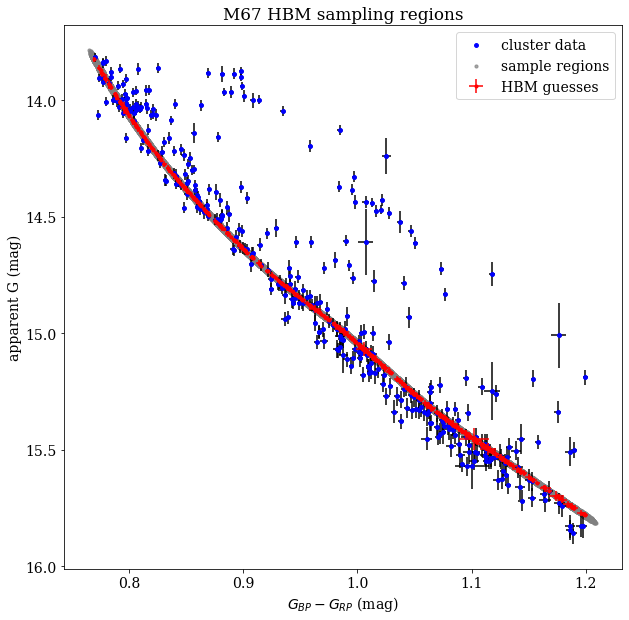

In [37]:
plotSample(trace, M67, 'M67 HBM sampling regions')